In [1]:
%load_ext autoreload
%autoreload 2


In [4]:
from datasets import load_dataset
cache_dir = "/storage/agrp/barakma/hg_cache"
# Load first 100 rows of each configuration
particles = load_dataset("OpenDataDetector/ColliderML_ttbar_pu0", "particles", split="train[:100]", cache_dir=cache_dir)
print(f"Loaded {len(particles)} particle events")

#tracker_hits = load_dataset("OpenDataDetector/ColliderML_ttbar_pu0", "tracker_hits", split="train[:100]")
calo_hits = load_dataset("OpenDataDetector/ColliderML_ttbar_pu0", "calo_hits", split="train[:100]", cache_dir=cache_dir)
print(f"Loaded {len(calo_hits)} calo hit events")

tracks = load_dataset("OpenDataDetector/ColliderML_ttbar_pu0", "tracks", split="train[:100]", cache_dir=cache_dir)

#print(f"Loaded {len(tracker_hits)} tracker hit events")
print(f"Loaded {len(tracks)} track events")


Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loaded 100 particle events


Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loaded 100 calo hit events


Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loaded 100 track events


In [5]:
d = {'particles': particles, 'calo_hits': calo_hits, 'tracks': tracks}
import pickle
import gzip
with gzip.open('primary_particles.pkl.gz', 'wb') as f:
    pickle.dump(d, f)

In [6]:
# read it back
import pickle
import gzip

with gzip.open('primary_particles.pkl.gz', 'rb') as f:
    all_datasets_loaded = pickle.load(f)   

In [7]:
all_datasets_loaded

{'particles': Dataset({
     features: ['event_id', 'particle_id', 'pdg_id', 'mass', 'energy', 'charge', 'vx', 'vy', 'vz', 'time', 'px', 'py', 'pz', 'vertex_primary', 'parent_id'],
     num_rows: 100
 }),
 'calo_hits': Dataset({
     features: ['event_id', 'detector', 'total_energy', 'x', 'y', 'z', 'contrib_particle_ids', 'contrib_energies', 'contrib_times'],
     num_rows: 100
 }),
 'tracks': Dataset({
     features: ['event_id', 'd0', 'z0', 'phi', 'theta', 'qop', 'majority_particle_id', 'hit_ids', 'track_id'],
     num_rows: 100
 })}

In [8]:
from cluster.load_data import load_dataset_to_ram_optimized    
# ---------------------------------------------------------
# Main Logic
# ---------------------------------------------------------

# Container for your completely in-memory datasets
# Structure: memory_datasets[ds_name][config][split]
dataset_to_load = ['calo_hits', 'particles', 'tracks']

memory_datasets = {}
for cfg_name in dataset_to_load:
    original_ds = all_datasets_loaded[cfg_name]
    ds_name = "OpenDataDetector/ColliderML_ttbar_pu0"
    # 1. Get the file paths from the existing dataset object
    # (The attribute is typically a list of dicts provided by the backend)
    target_files = original_ds.cache_files
    
    # 2. Load them into RAM
    ram_ds = load_dataset_to_ram_optimized(target_files)
    

    memory_datasets[cfg_name] = ram_ds
    print(f"  -> Success! Loaded {len(ram_ds)} rows into RAM.")
   
print("\n===============================================")
print("ALL DATA LOADED TO RAM.")
print("Access example: memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][0]")

Loading: collider_ml_ttbar_pu0-train-00000-of-00100.arrow
Concatenating in memory...
  -> Success! Loaded 978 rows into RAM.
Loading: collider_ml_ttbar_pu0-train-00000-of-00100.arrow
Concatenating in memory...
  -> Success! Loaded 1000 rows into RAM.
Loading: collider_ml_ttbar_pu0-train-00000-of-00002.arrow
Concatenating in memory...
  -> Success! Loaded 87000 rows into RAM.

ALL DATA LOADED TO RAM.
Access example: memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][0]


Processing first 100 events for histogram...


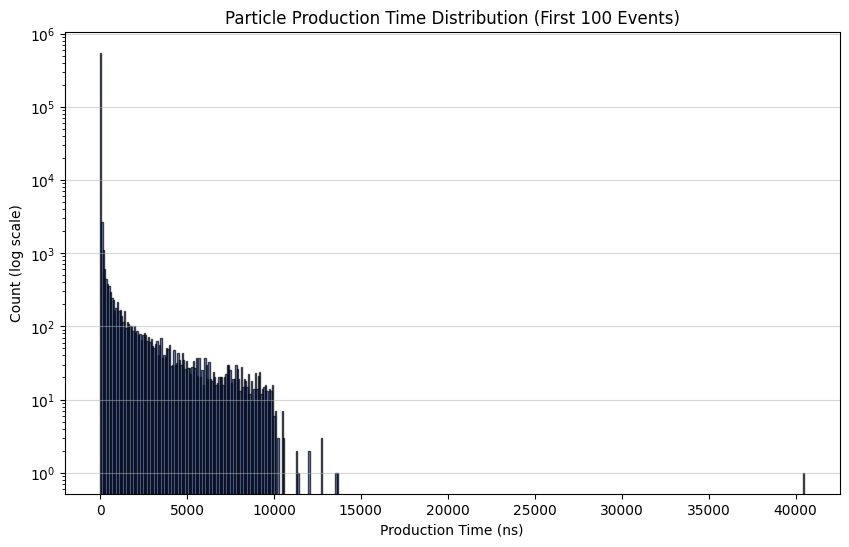

Total particles plotted: 558678
Mean time: 45.8918 ns
Max time:  40512.1602 ns


In [ ]:
from primary.plot import plot_production_time_histogram
plot_production_time_histogram(memory_datasets['particles'], n_events=100, bins=500, log_scale=True)

In [4]:
particles = memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train']
calo_hits = memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['calo_hits']['train']
tracks = memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['tracks']['train']

In [7]:
from primary.preprocessing import add_orphan_mask, cast_parent_id_to_int64
particles = cast_parent_id_to_int64(particles)
particles = add_orphan_mask(particles)

Computing parent existence mask...


In [51]:
event_idx = 0
indices = (particles[event_idx]['is_parent_missing'][0] == True).arg_true()
print(indices)


shape: (80,)
Series: '' [u32]
[
	0
	1
	2
	3
	4
	…
	153
	154
	155
	174
	175
]


In [ ]:
type(pl.col("is_parent_missing") == True)

polars.expr.expr.Expr

In [46]:

event_idx = 0
particle_ids = particles[event_idx]["particle_id"][0]
(particle_ids == 9).arg_true().to_list()

[]

Processing first 100 events for histogram...


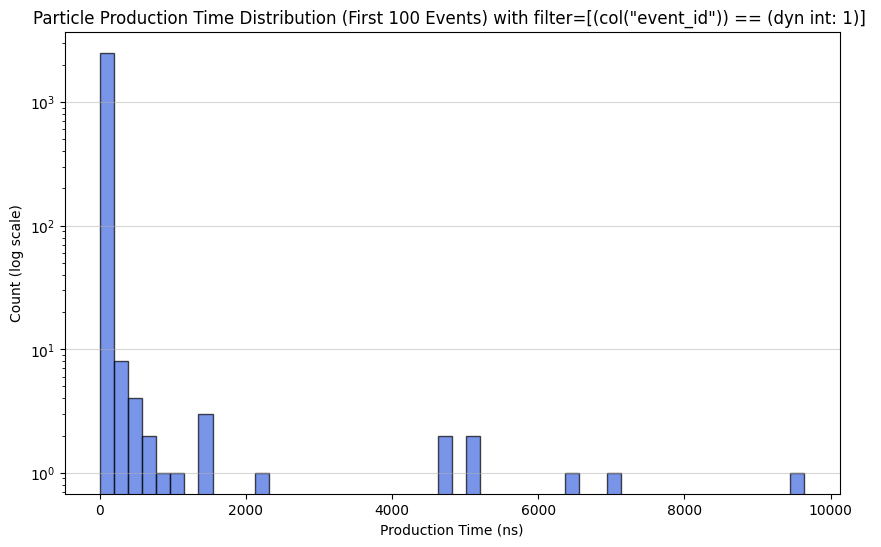

Total particles plotted: 2532
Mean time: 34.1846 ns
Max time:  9642.1289 ns


In [15]:
import polars as pl

from primary.plot import plot_production_time_histogram
plot_production_time_histogram(particles, n_events=100, bins=50, log_scale=True, filter_expression=pl.col("event_id") == 1)#

In [31]:
from primary.preprocessing import map_to_ultimate_ancestor
particles_with_lineage = map_to_ultimate_ancestor(particles[5])

Mapping lineage (Pointer Jumping with Self-Loops)...


KeyboardInterrupt: 

In [22]:
particles[5]['particle_id'][0], particles[5]['parent_id'][0], 

(shape: (5_085,)
 Series: '' [i64]
 [
 	39
 	40
 	41
 	42
 	43
 	…
 	5737
 	5738
 	5739
 	5740
 	5741
 ],
 shape: (5_085,)
 Series: '' [i64]
 [
 	9
 	9
 	9
 	9
 	9
 	…
 	5739
 	null
 	null
 	null
 	null
 ])

In [34]:
particles[5]['parent_id'][0].to_list()

[9,
 9,
 9,
 9,
 9,
 9,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 41,
 41,
 43,
 43,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 168,
 168,
 173,
 173,
 174,
 174,
 175,
 175,
 176,
 176,
 177,
 177,
 178,
 178,
 178,
 180,
 180,
 183,
 183,
 188,
 188,
 188,
 191,
 191,
 192,
 193,
 193,
 195,
 195,
 198,
 198,
 201,
 201,
 201,
 222,
 222,
 225,
 225,
 226,
 227,
 227,
 391,
 391,
 392,
 392,
 393,
 393,
 394,
 394,
 395,
 395,
 396,
 396,
 397,
 397,
 398,
 398,
 399,
 399,
 401,
 401,
 401,
 404,
 404,
 406,
 406,
 406,
 409,
 409,
 410,
 410,
 412,
 412,
 415,
 415,
 416,
 416,
 416,
 421,
 429,
 429,
 429,
 433,
 433,
 4

In [ ]:
memory_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][5]

parent_id
list[f64]
"[9.0, 9.0, … null]"


In [38]:
import pandas as pd

def get_ancestors_with_cycle_detection(ids, parent_ids):
    # 1. Fast lookup map
    parent_map = dict(zip(ids, parent_ids))
    
    # 2. Memoization dictionary to store final root for every ID
    #    If a node is part of a cycle, we map it to None (or a specific flag)
    #    to prevent infinite loops in future lookups.
    ancestors = {}

    for node in ids:
        # If already calculated, skip
        if node in ancestors:
            continue

        path = []
        path_set = set() # For O(1) cycle checking
        curr = node
        
        root_found = None
        
        while True:
            # Add current node to path
            path.append(curr)
            path_set.add(curr)
            
            # Get parent
            parent = parent_map.get(curr)

            # --- END CONDITION 1: Natural Root (None) ---
            if parent is None:
                root_found = curr
                break
            
            # --- END CONDITION 2: Self-Loop ---
            if parent == curr:
                # Technically a cycle, usually treated as a root in this context
                root_found = curr
                break

            # --- END CONDITION 3: Hit a previously calculated node ---
            if parent in ancestors:
                root_found = ancestors[parent]
                break

            # --- END CONDITION 4: Cycle Detected (Loop) ---
            if parent in path_set:
                # We found a cycle. 
                # Let's extract exactly which nodes are looping.
                cycle_start_index = path.index(parent)
                cycle_nodes = path[cycle_start_index:]
                
                # Print the cycle
                print(f"Cycle Detected: {' -> '.join(map(str, cycle_nodes))} -> {parent}")
                
                # We define the 'root' of a cycle as None (or you could mark it as "Cycle")
                root_found = None 
                break
            
            # Move up
            curr = parent
        
        # --- Path Compression ---
        # Assign the found result to everyone in the path so we never process them again.
        for p in path:
            ancestors[p] = root_found

    return ancestors

# Usage
df = pd.DataFrame({'id': particles[5]['particle_id'][0].to_list(), 'parent_id': particles[5]['parent_id'][0].to_list()})
df['root_id'] = get_ancestors_with_cycle_detection(df['id'], df['parent_id'])
print(df)

Cycle Detected: 1150.0 -> 1153.0 -> 1150.0
Cycle Detected: 1160 -> 1161.0 -> 1160.0
Cycle Detected: 1228.0 -> 1230.0 -> 1228.0
Cycle Detected: 1259.0 -> 1262.0 -> 1259.0
Cycle Detected: 1268.0 -> 1265.0 -> 1268.0
Cycle Detected: 1325.0 -> 1322.0 -> 1325.0
Cycle Detected: 1359.0 -> 1361.0 -> 1359.0
Cycle Detected: 1460.0 -> 1461.0 -> 1460.0
Cycle Detected: 1481.0 -> 1484.0 -> 1487.0 -> 1490.0 -> 1480.0 -> 1481.0
Cycle Detected: 1587.0 -> 1586.0 -> 1587.0
Cycle Detected: 1602.0 -> 1605.0 -> 1602.0
Cycle Detected: 1627.0 -> 1630.0 -> 1627.0
Cycle Detected: 1728.0 -> 1727.0 -> 1728.0
Cycle Detected: 1740.0 -> 1739.0 -> 1740.0
Cycle Detected: 1767.0 -> 1770.0 -> 1766.0 -> 1769.0 -> 1768.0 -> 1771.0 -> 1765.0 -> 1767.0
Cycle Detected: 1803.0 -> 1806.0 -> 1803.0
Cycle Detected: 1889.0 -> 1888.0 -> 1889.0
Cycle Detected: 1900.0 -> 1899.0 -> 1901.0 -> 1898.0 -> 1900.0
Cycle Detected: 1921.0 -> 1922.0 -> 1921.0
Cycle Detected: 1957 -> 1960.0 -> 1957.0
Cycle Detected: 1985.0 -> 1988.0 -> 1985.0
C

ValueError: cannot reindex on an axis with duplicate labels

In [7]:
particle_ids = particles[5]['particle_id'][0]
parent_ids = particles[5]['parent_id'][0]
particles_time = particles[5]['time'][0]
index = (particle_ids == 1150).arg_true().to_list()[0]
print(index)
parent_exact_id = parent_ids[index] 
particle_time = particles_time[index]
print(parent_exact_id)
parent_index = (particle_ids == parent_exact_id).arg_true().to_list()[0]
parent_time = particles_time[parent_index]
print(parent_index)
parent_parent_id = parent_ids[parent_index]
print(parent_parent_id)
print(f"Summary: Particle {particle_ids[index]}, index: {index}, creation time: {particle_time} has parent {parent_exact_id}, parent_index: {parent_index}, parent creation time: {parent_time} whose parent is {parent_parent_id}")

493
1153.0
496
1150.0
Summary: Particle 1150, index: 493, creation time: 2.123812437057495 has parent 1153.0, parent_index: 496, parent creation time: 4.163594722747803 whose parent is 1150.0


In [17]:
import polars as pl
exploded = particles.head(10).explode([ "particle_id"])
# select particle_id,event_id
result = (
    exploded.select(["event_id", "particle_id"])
)
result

event_id,particle_id
i64,i64
0,76
0,77
0,78
0,79
0,80
…,…
9,6966
9,6967
9,6968


In [16]:
import polars as pl
exploded = particles.head(10).explode([ "particle_id"])
result = (
    exploded.group_by(["event_id", "particle_id"])
            .agg(pl.len().alias("count"))
          
)
result

event_id,particle_id,count
i64,i64,u32
1,2399,1
0,964,1
8,2672,1
7,6269,1
7,2721,1
…,…,…
6,5374,1
5,5216,1
6,1817,1


In [14]:
particles

event_id,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,px,py,pz,vertex_primary,parent_id,is_parent_missing
i64,list[i64],list[i64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[i64],list[i64],list[bool]
0,"[76, 77, … 1977]","[213, -211, … 2212]","[0.738762, 0.13957, … 0.938272]","[2491.611858, 489.56621, … 1.464839]","[1.0, -1.0, … 1.0]","[0.009162, 0.009162, … 2159.469482]","[-0.003694, -0.003694, … 1843.329346]","[196.070236, 196.070236, … -210.282364]","[11.958187, 11.958187, … 22.085659]","[0.033283, -0.342658, … 0.853529]","[-0.117263, 0.317618, … 0.710063]","[2491.611816, 489.565979, … 0.180822]","[1, 1, … 1]","[9, 9, … 1976]","[true, true, … false]"
1,"[10, 11, … 2692]","[211, -211, … 22]","[0.13957, 0.13957, … 0.0]","[1935.443866, 28.814048, … 222.092745]","[1.0, -1.0, … 0.0]","[-0.023709, -0.023709, … -0.023614]","[0.010315, 0.010315, … 0.010545]","[106.12365, 106.12365, … 106.042526]","[4.075578, 4.075578, … 4.075848]","[-0.005252, 0.212135, … 0.30518]","[0.20687, -0.101696, … 0.58315]","[1935.443848, 28.81275, … -222.091766]","[1, 1, … 1]","[3, 3, … 80]","[true, true, … false]"
2,"[64, 65, … 3226]","[-523, 111, … -11]","[5.3252, 0.13498, … 0.000511]","[18.453095, 3.594066, … 0.362266]","[0.0, 0.0, … 1.0]","[-0.013339, -0.013339, … 16.921406]","[-0.005375, -0.005375, … 1308.693481]","[49.383862, 49.383862, … -1014.986938]","[0.945178, 0.945178, … 6.572384]","[17.1297, 3.394495, … 0.009029]","[-2.952355, -0.652638, … 0.275271]","[3.164794, 0.974962, … -0.235331]","[1, 1, … 1]","[9, 9, … 3213]","[true, true, … false]"
3,"[43, 44, … 4354]","[2212, 221, … 22]","[0.93827, 0.54785, … 0.0]","[22.615156, 25.405206, … 2.882969]","[1.0, 0.0, … 0.0]","[0.008929, 0.008929, … 0.008919]","[-0.012789, -0.012789, … -0.012751]","[61.058159, 61.058159, … 61.060184]","[-2.133011, -2.133011, … -2.133004]","[0.010547, -0.045738, … -0.013601]","[0.230913, 0.842978, … 0.074248]","[22.594501, 25.385263, … 2.881981]","[1, 1, … 1]","[8, 8, … 136]","[true, true, … false]"
4,"[113, 114, … 2269]","[223, 211, … 11]","[0.780666, 0.13957, … 0.000511]","[144.329089, 1.095027, … 0.139602]","[0.0, 1.0, … -1.0]","[0.006297, 0.006297, … 789.904236]","[0.01418, 0.01418, … -1050.674683]","[52.569878, 52.569878, … 1126.600952]","[-7.506285, -7.506285, … -1.779469]","[-0.278494, 0.021264, … 0.017909]","[0.013545, 0.021074, … -0.108077]","[144.326706, 1.085683, … 0.086528]","[1, 1, … 1]","[8, 8, … 2263]","[true, true, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
995,"[80, 81, … 5640]","[-321, 223, … 11]","[0.49368, 0.793777, … 0.000511]","[28.717168, 8.620346, … 0.000618]","[-1.0, 0.0, … -1.0]","[-0.006419, -0.006419, … 657.985657]","[-0.011553, -0.011553, … -44.434826]","[-75.322754, -75.322754, … -896.249573]","[-10.286097, -10.286097, … 0.747436]","[-11.782568, -3.758275, … 0.000138]","[6.858037, 2.032827, … -0.000308]","[-25.269951, -7.44468, … -0.000084]","[1, 1, … 1]","[9, 9, … 5639]","[true, true, … false]"
996,"[29, 30, … 6055]","[-211, 111, … 211]","[0.13957, 0.13498, … 0.1395701]","[1.356178, 0.223959, … 0.394234]","[-1.0, 0.0, … 1.0]","[-0.000957, -0.000957, … 764.739319]","[0.005772, 0.005772, … -1481.490234]","[-1.210217, -1.210217, … -1178.932739]","[6.712732, 6.712732, … 13.60649]","[-0.174356, 0.102382, … -0.072125]","[0.433903, -0.041758, … -0.34707]","[1.265332, 0.1404, … -0.101396]","[1, 1, … 1]","[9, 9, … 6054]","[true, true, … false]"
997,"[145, 146, … 7849]","[221, 111, … 11]","[0.54785, 0.13498, … 0.000511]","[2.467179, 0.135171, … 0.000517]","[0.0, 0.0, … -1.0]","[0.009254, 0.009254, … 428.086304]","[-0.000325, -0.000325, … -501.950165]","[86.061668, 86.061668, … 1074.772827]","[8.644897, 8.644897, … 20.044153]","[1.394695, -0.006932, … -0.000056]","[0.625924, 0.001811, … 0.000044]","[1.857385, 0.000576, … -0.000033]","[1, 1, … 1]","[8, 8, … 7842]","[true, true, … false]"
